<a href="https://colab.research.google.com/github/erichsiao1106/lung_ct/blob/master/keras_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm.auto import tqdm

In [ ]:
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

## Load and resize the images

In [ ]:
IMAGE_LIB = 'drive/My Drive/class/勞動部/week9/lung_ct/2d_images/*.tif'
MASK_LIB = 'drive/My Drive/class/勞動部/week9/lung_ct/2d_masks/*.tif'
IMG_SIZE = 256
SEED = 5566

In [ ]:
img_paths = sorted(glob(IMAGE_LIB))[:10] # demo for 10 images only
mask_paths = sorted(glob(MASK_LIB))[:10] # demo for 10 images only

x_data = np.empty((len(img_paths), IMG_SIZE, IMG_SIZE))
y_data = np.empty((len(img_paths), IMG_SIZE, IMG_SIZE))

for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    x_data[i] = img

for i, path in tqdm(enumerate(mask_paths)):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED) / 255.
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    y_data[i] = img

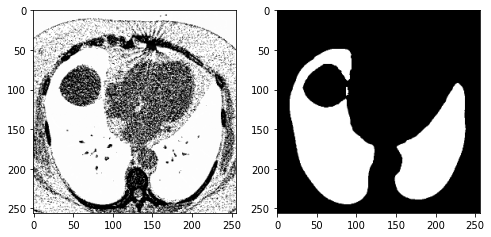

In [ ]:
i = np.random.randint(0, x_data.shape[0])
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[i], cmap='gray')
ax[1].imshow(y_data[i], cmap='gray')
plt.show()

In [ ]:
x_data = np.expand_dims(x_data, axis=-1)
y_data = np.expand_dims(y_data, axis=-1)
x_data.shape, y_data.shape

((10, 256, 256, 1), (10, 256, 256, 1))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state=5566)

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((8, 256, 256, 1), (2, 256, 256, 1), (8, 256, 256, 1), (2, 256, 256, 1))

## Define and train model

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)

output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 1168        max_pooling2d[0][0]              
_______________________________________________________________________________________

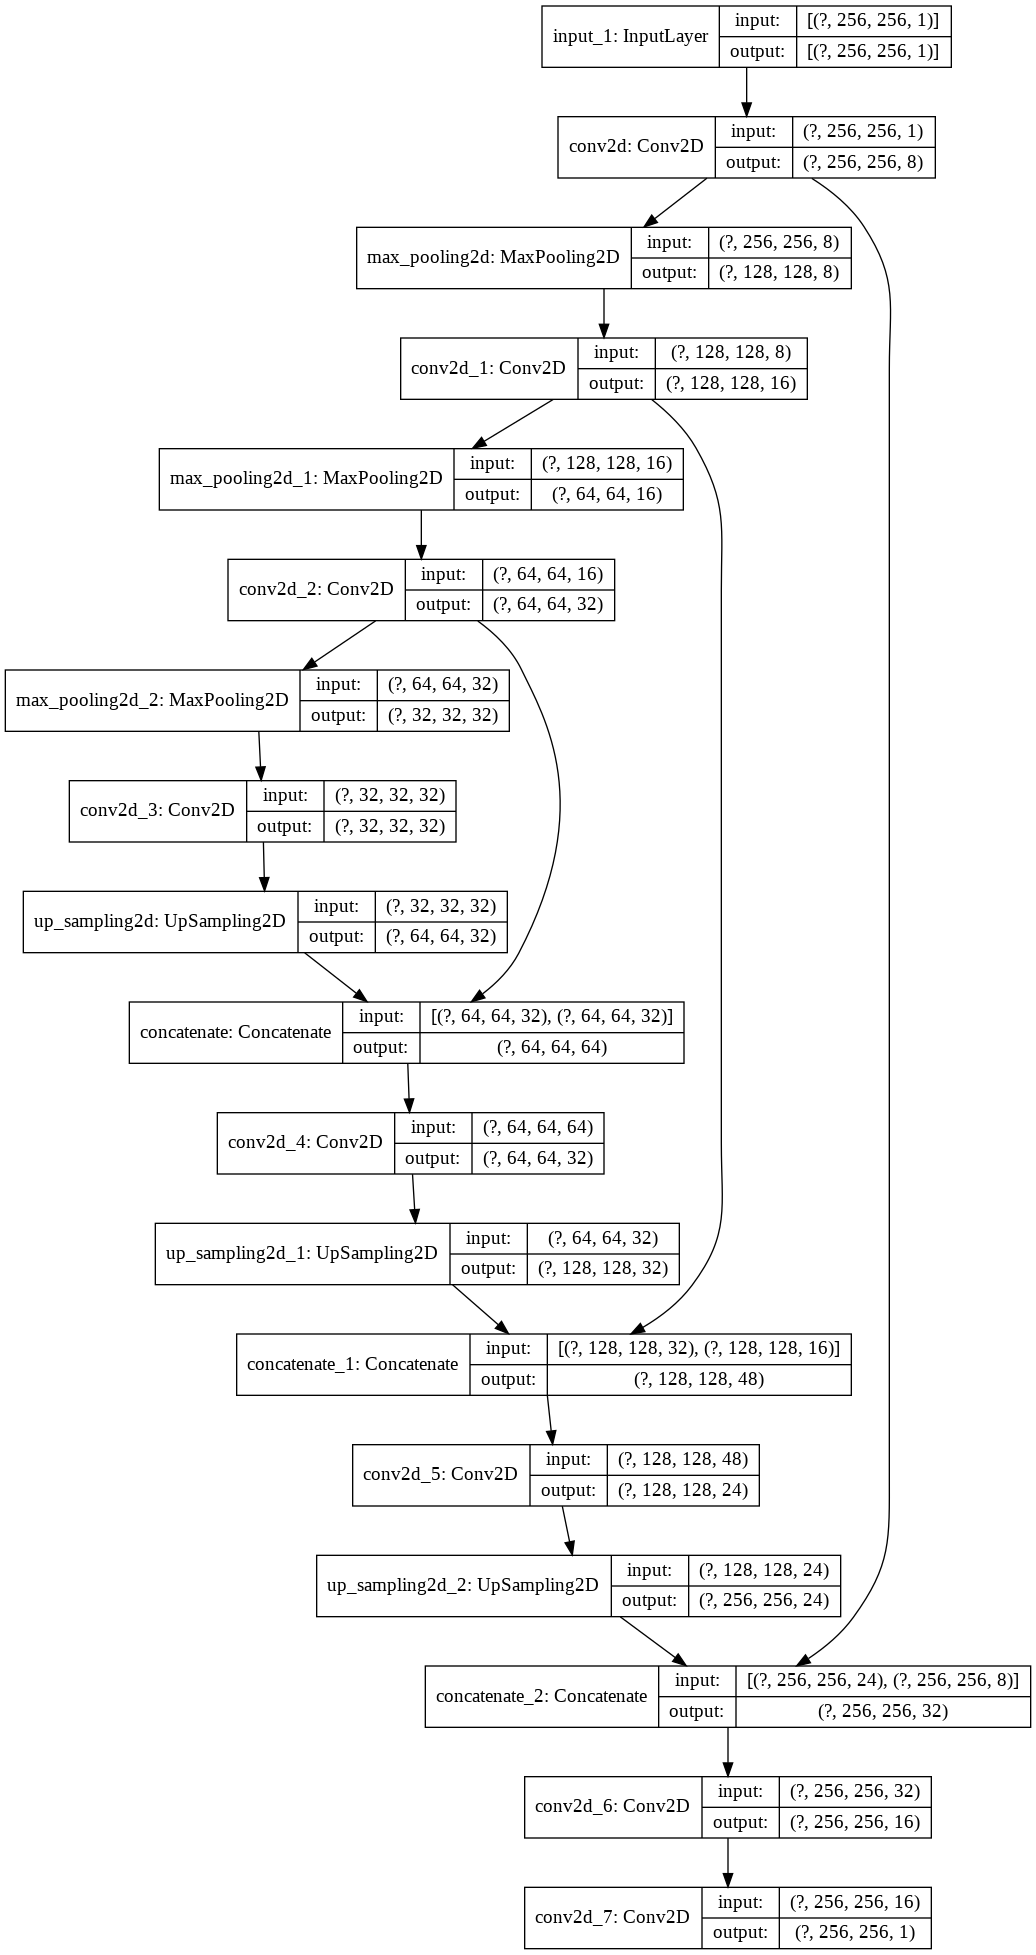

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, y_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

By using the same RNG seed in both calls to ImageDataGenerator, we should get images and masks that correspond to each other. Let's check this, to be safe.

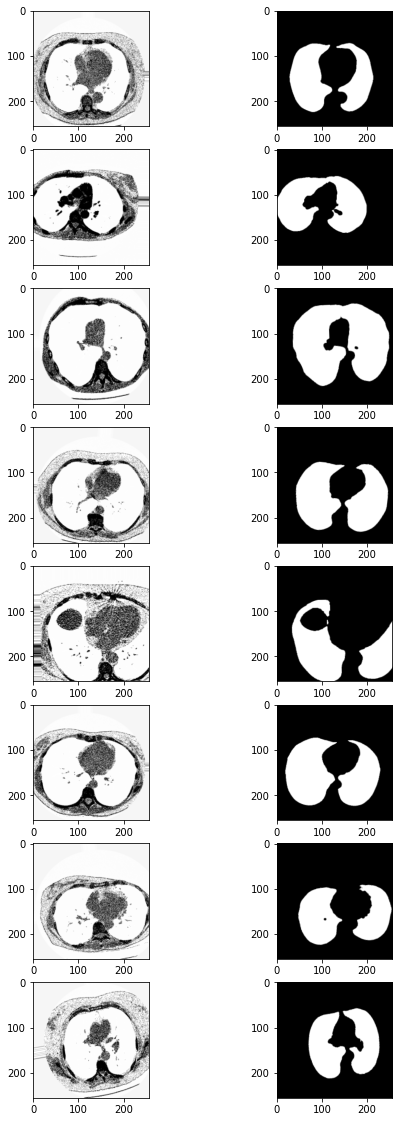

In [ ]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap=plt.cm.gray)
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap=plt.cm.gray)
plt.show()

In [ ]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[dice_coef])

In [ ]:
weight_saver = ModelCheckpoint('drive/My Drive/{epoch:02d}-{val_loss:.2f}.h5', monitor='val_dice_coef')
earlystop = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# hist = model.fit(x_train, y_train, batch_size=8,
#                    validation_data = (x_val, y_val),
#                    epochs=100, verbose=1,
#                    callbacks = [weight_saver, earlystop])
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=100, verbose=1,
                           callbacks = [weight_saver, earlystop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
200/200 [==============================] - 18s 91ms/step - loss: 0.3494 - dice_coef: 0.5593 - val_loss: 0.2199 - val_dice_coef: 0.6755
Epoch 2/100
200/200 [==============================] - 18s 89ms/step - loss: 0.1772 - dice_coef: 0.7928 - val_loss: 0.1107 - val_dice_coef: 0.8344
Epoch 3/100
 13/200 [>.............................] - ETA: 15s - loss: 0.1420 - dice_coef: 0.8344

KeyboardInterrupt: ignored

## Evaluate

In [ ]:
model_final = load_model('/content/drive/My Drive/class/勞動部/week9/lung_ct/19-0.17.h5', custom_objects={'dice_coef': dice_coef})
#model_final = load_model('drive/My Drive/class/北分署/week9/lung_ct/conv2dTranspose-18-0.13.h5', compile=False)

In [ ]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

1


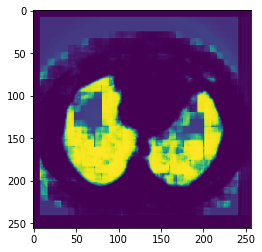

In [ ]:
idx = np.random.randint(x_val.shape[0])
print(idx)
img_test = x_val[idx]
mask_pred = model_final.predict(np.expand_dims(img_test, axis=0))
mask_pred = mask_pred.reshape((IMG_SIZE, IMG_SIZE))
plt.imshow(mask_pred, cmap='gray')

1


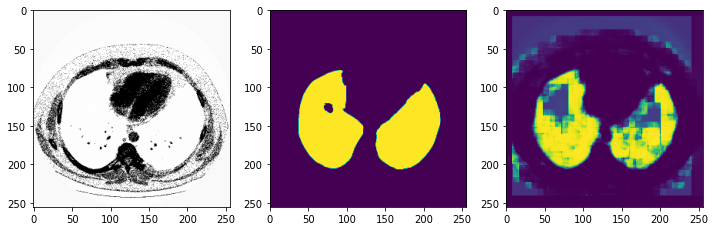

In [ ]:
idx = np.random.randint(x_val.shape[0])
print(idx)
y_hat = model_final.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[idx,:,:,0], cmap='gray')
ax[1].imshow(y_val[idx,:,:,0])
ax[2].imshow(y_hat[idx,:,:,0])

A good result, but it probably helped that these images are very homogeneous.

0


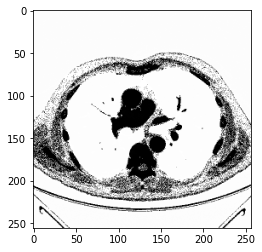

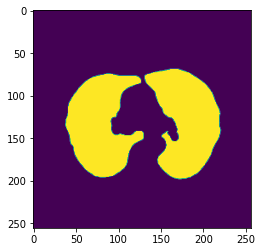

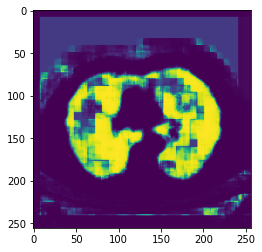

threshold: 0.1


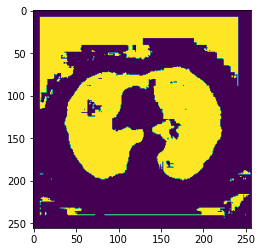

threshold: 0.2


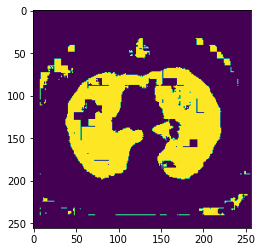

threshold: 0.30000000000000004


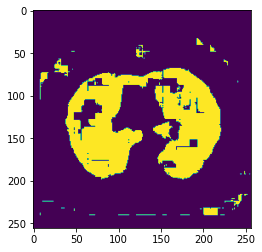

threshold: 0.4


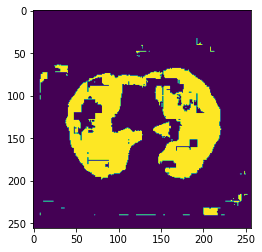

threshold: 0.5


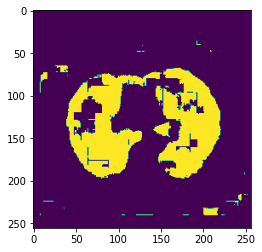

threshold: 0.6000000000000001


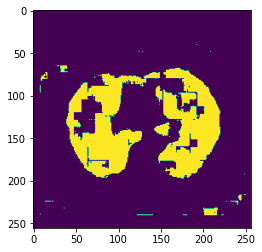

threshold: 0.7000000000000001


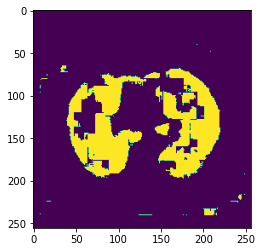

threshold: 0.8


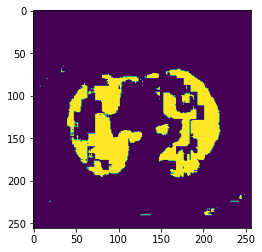

threshold: 0.9


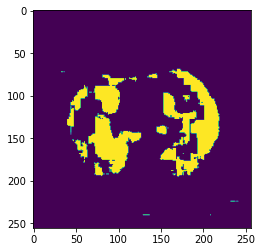

In [ ]:
# Different threshold
idx = np.random.randint(x_val.shape[0])
print(idx)
# input img
plt.imshow(x_val[idx].reshape((IMG_SIZE, IMG_SIZE)), cmap='gray')
plt.show()
# ground truth
plt.imshow(y_val[idx].reshape((IMG_SIZE, IMG_SIZE)))
plt.show()
# prediction
img_test = x_val[idx]
mask_pred = model_final.predict(np.expand_dims(img_test, axis=0))
mask_pred = mask_pred.reshape((IMG_SIZE, IMG_SIZE))
plt.imshow(mask_pred)
plt.show()
# prediction with different threshold
for i in range(1,10):
    threshold = 0.1 * i
    print(f'threshold: {threshold}')
    mask_threshold = mask_pred.copy()
    mask_threshold[mask_threshold >= threshold] = 1
    mask_threshold[mask_threshold < threshold] = 0
    plt.imshow(mask_threshold)
    plt.show()